## Discontinuous Step Function

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import chain
import seaborn as sns
import os
import math
import time
import pdb
cuda = torch.cuda.is_available()

In [45]:
N = 1000
n = 500
num_epoch = 300
lr = 1e-3
batch_size = 64

def f(x):
    if(x < 0.10) :
        y = 0.3 + 0.6 * x 
    elif(x >= 0.10 and x < 0.20) :
        y = -0.4 - 0.5 * x 
    elif (x >= 0.20 and x < 0.35) :
        y = np.sin(300*x**2)
    elif (x >= 0.35 and x < 0.65):
        y = -0.7 + 0.5 * x**2
    elif (x >= 0.65 and x < 0.85):
        y = -0.7+1.5*(1- np.exp(-(x-0.6)/0.05))
    else :
        y = np.sin(100*x**2)
    return y

## Gaussian Noise

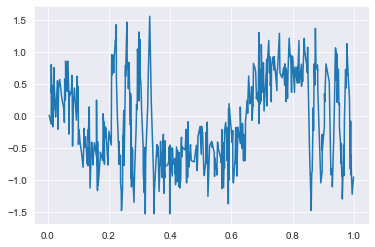

In [46]:
np.random.seed(0)
x_train = np.random.random(size=(n, 1))
x_train = np.sort(x_train, axis=0)
# Gaussian Noise
y_train = (np.apply_along_axis(f, 1, x_train).reshape(-1, 1) + np.random.normal(0.0, 0.3, size=x_train.shape))
start_date = pd.Timestamp('1/1/2018')
end_date = start_date + pd.DateOffset(len(y_train) - 1)
timeSeries = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date), 'value': y_train.flatten()})
plt.plot(x_train, y_train)

## Gamma

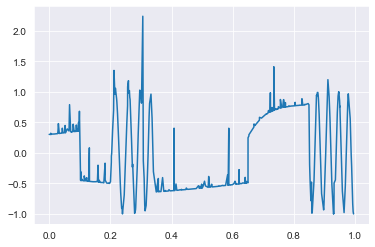

In [54]:
x_train = np.random.random(size=(n, 1))
x_train = np.sort(x_train, axis=0)
# log normal Noise
y_train= (np.apply_along_axis(f,1,x_train).reshape(-1,1) + np.random.gamma(.1, scale=.3, size=x_train.shape))
start_date = pd.Timestamp('1/1/2018')
end_date = start_date + pd.DateOffset(len(y_train) - 1)
timeSeries = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date), 'value': y_train.flatten()})
plt.plot(x_train, y_train)

# Sinusoid with Log Normal Distribution

In [63]:
def f(x):
    return (x+0.5>=0)*np.sin(4*(x+0.5)**4)#-1.0*(x>0)+numpy.

het_noise = 1
N = 1000

if het_noise == 1:
    n = 500
else:
    n= 50

np.random.seed(0)
x_train = np.random.random(size=(n,1)) - 0.5

## noise model
def obs_noise(x):
    if x > 0.2:
        return 0
    else:
        x = abs(x-0.2)
        return float(np.random.normal(0,x,size=1))

if het_noise == 1 :
    ## Heteroscedastic Observation Noise
    y_train = f(x_train) + np.apply_along_axis(obs_noise,1,x_train).reshape(-1,1)
else :    
    ## Homoscedastic Observation Noise
    y_train = f(x_train) + np.random.normal(0.0,0.01,size=x_train.shape)

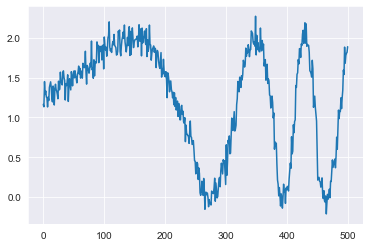

In [65]:
np.random.seed(0)
x_train = np.random.random(size=(n, 1))
x_train = np.sort(x_train, axis=0)
# x_train = np.expand_dims(np.arange(n), axis=1)
# Gaussian Noise
y_train= (np.apply_along_axis(f,1,x_train).reshape(-1,1) + np.random.lognormal(0.0, 0.1,size=x_train.shape))
start_date = pd.Timestamp('1/1/2018')
end_date = start_date + pd.DateOffset(len(y_train) - 1)
timeSeries = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date), 'value': y_train.flatten()})
plt.plot(np.expand_dims(np.arange(len(x_train)), axis=1), y_train)

## Model and training functions

In [55]:
class RNNModel(nn.Module):
    '''
    RNN model with hidden and multiple stacked layer for time series prediction.
    '''
    def __init__(self, input_dim, hidden_dim, layer_dim, nonlinearity, quantiles=None):
        super(RNNModel, self).__init__()
        self.quantiles = quantiles
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        if self.quantiles is not None:
            rnns = [nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity=nonlinearity) for _ in range(len(self.quantiles))]
            final_layers = [nn.Linear(hidden_dim, 1) for _ in range(len(self.quantiles))]
            self.rnn = nn.ModuleList(rnns)
            self.final_layers = nn.ModuleList(final_layers)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity=nonlinearity)
            self.final_layers = nn.Linear(hidden_dim, 1)
        self.init_weights()

    def init_weights(self):
        if self.quantiles is not None:
            for m in chain(self.final_layers):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)
        else:
            nn.init.orthogonal_(self.final_layers.weight)
            nn.init.constant_(self.final_layers.bias, 0)

    def forward(self, x):
        if self.quantiles is not None:
            if cuda:
                h0s = [Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()) for _ in range(len(self.quantiles))]
            else:
                h0s = [Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)) for _ in range(len(self.quantiles))]
            outputs = []
            for rnn, h0, layer in zip(self.rnn, h0s, self.final_layers):
                out, _ = rnn(x, h0)
                output = layer(out[:, -1, :])
                outputs.append(output)
            return torch.cat(outputs, dim=1)
        else:
            if cuda:
                h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).cuda()
            else:
                h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            out, _ = self.rnn(x, h0)
            output = self.final_layers(out[:, -1, :])
            return output

In [56]:
def train(data, X, Y, model, criterion, optim, batch_size):
    model.train()
    total_loss = 0
    n_samples = 0
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad()
        output = model(X)
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale)
        loss.backward()
        optim.step()
        total_loss += loss.data.cpu().numpy()
        n_samples += (output.size(0) * data.m)
    return total_loss / n_samples

def evaluate(data, X, Y, model, criterion, batch_size):
    model.eval()
    total_loss = 0
    n_samples = 0
    predict = None
    test = None
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X)
        
        if predict is None:
            predict = output
            test = Y
        else:
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data.scale.expand(output.size(0), data.m)
        total_loss += criterion(output * scale, Y * scale).data.cpu().numpy()
        n_samples += (output.size(0) * data.m)
    return total_loss / n_samples

def get_mape(target, pred):
    MAPE = 100 * np.mean(np.absolute(target - pred)) / np.mean(np.absolute(target))
    return MAPE

def get_llh(target, upper, median, lower, t_upper, t_lower, t_median, upper_loss, median_loss, lower_loss):
    target = torch.tensor(np.expand_dims(target, axis=1), requires_grad=False)
    upper = torch.tensor(np.expand_dims(upper, axis=1), requires_grad=False)
    median = torch.tensor(np.expand_dims(median, axis=1), requires_grad=False)
    lower = torch.tensor(np.expand_dims(lower, axis=1), requires_grad=False)
    t_upper = torch.tensor(t_upper, requires_grad=False)
    t_lower = torch.tensor(t_lower, requires_grad=False)
    t_median = torch.tensor(t_median, requires_grad=False)
    
    Q = (upper_loss(upper, target) + lower_loss(lower, target) + median_loss(median, target)) / 3
    q = (upper_loss(t_upper, target[1:, :]) + lower_loss(t_lower, target[1:, :]) + median_loss(t_median, target[1:, :])) / 3
    return Q / q

## Training and validation

In [57]:
training, validation = 0.6, 0.2
Data = utils.Data_utility(train=training, valid=validation, cuda=cuda, horizon=1, window=128, dataset=y_train)
# Bagging: 10 ensemble of estimators, each model trained with random 64 samples.
index_list = []
for i in range(10):
    num_sample = Data.train[0].shape[0]
    index_list.append(np.random.randint(low=0, high=num_sample, size=64))
    
criterion = nn.MSELoss(reduction='sum') #reduction
models, optims = {}, {}
for i in range(10):
    models[i] = RNNModel(input_dim=1, hidden_dim=5, layer_dim=2, nonlinearity='tanh')
    optims[i] = torch.optim.Adam(models[i].parameters(), lr=lr)
    
start = time.time()
for i in range(len(index_list)):
    best_val = 10000000
    print('Begin training for estimator {}: '.format(i))
    for epoch in range(1, num_epoch):
        train_loss = train(Data, Data.train[0][index_list[i]], Data.train[1][index_list[i]], models[i], criterion,
                           optims[i], batch_size)
        val_loss = evaluate(Data, Data.valid[0], Data.valid[1], models[i], criterion, batch_size)
        if epoch % 10 == 0:
            print('Epoch [{:3d}]: training loss {:5.4f} | validation loss {:5.4f}.'.format(epoch, train_loss, val_loss))
        if val_loss < best_val:
            with open('./saved_model/rnn_' + str(i) + '.pt', 'wb') as f:
                torch.save(models[i], f)
            best_val = val_loss
print('Training time: ', time.time() - start)

models = {}
for i in range(len(index_list)):
    with open('./saved_model/rnn_' + str(i) + '.pt', 'rb') as f:
        models[i] = torch.load(f)
result = np.zeros((Data.test[0].shape[0], 10))
for i in range(len(index_list)):
    result[:, i] = models[i](Data.test[0]).cpu().detach().numpy().flatten()
res_var = np.var(result, axis=1)
res_mean = np.mean(result, axis=1)

Begin training for estimator 0: 


/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [ 10]: training loss 0.7985 | validation loss 0.2949.
Epoch [ 20]: training loss 0.5124 | validation loss 0.2483.
Epoch [ 30]: training loss 0.3658 | validation loss 0.2822.
Epoch [ 40]: training loss 0.3118 | validation loss 0.3405.
Epoch [ 50]: training loss 0.2968 | validation loss 0.3704.
Epoch [ 60]: training loss 0.2851 | validation loss 0.3535.
Epoch [ 70]: training loss 0.2691 | validation loss 0.3081.
Epoch [ 80]: training loss 0.2526 | validation loss 0.2591.
Epoch [ 90]: training loss 0.2370 | validation loss 0.2177.
Epoch [100]: training loss 0.2221 | validation loss 0.1831.
Epoch [110]: training loss 0.2085 | validation loss 0.1515.
Epoch [120]: training loss 0.1965 | validation loss 0.1219.
Epoch [130]: training loss 0.1860 | validation loss 0.0966.
Epoch [140]: training loss 0.1768 | validation loss 0.0769.
Epoch [150]: training loss 0.1688 | validation loss 0.0620.
Epoch [160]: training loss 0.1617 | validation loss 0.0507.
Epoch [170]: training loss 0.1553 | vali

Epoch [200]: training loss 0.0530 | validation loss 0.0353.
Epoch [210]: training loss 0.0527 | validation loss 0.0353.
Epoch [220]: training loss 0.0524 | validation loss 0.0356.
Epoch [230]: training loss 0.0520 | validation loss 0.0361.
Epoch [240]: training loss 0.0517 | validation loss 0.0365.
Epoch [250]: training loss 0.0514 | validation loss 0.0369.
Epoch [260]: training loss 0.0511 | validation loss 0.0372.
Epoch [270]: training loss 0.0508 | validation loss 0.0376.
Epoch [280]: training loss 0.0505 | validation loss 0.0381.
Epoch [290]: training loss 0.0501 | validation loss 0.0385.
Begin training for estimator 5: 
Epoch [ 10]: training loss 1.4416 | validation loss 0.5291.
Epoch [ 20]: training loss 0.7890 | validation loss 0.2996.
Epoch [ 30]: training loss 0.4204 | validation loss 0.2870.
Epoch [ 40]: training loss 0.2596 | validation loss 0.4010.
Epoch [ 50]: training loss 0.2192 | validation loss 0.5288.
Epoch [ 60]: training loss 0.2149 | validation loss 0.5824.
Epoch [

Epoch [ 90]: training loss 0.3002 | validation loss 0.5360.
Epoch [100]: training loss 0.2957 | validation loss 0.5201.
Epoch [110]: training loss 0.2908 | validation loss 0.5042.
Epoch [120]: training loss 0.2854 | validation loss 0.4904.
Epoch [130]: training loss 0.2794 | validation loss 0.4771.
Epoch [140]: training loss 0.2725 | validation loss 0.4619.
Epoch [150]: training loss 0.2645 | validation loss 0.4434.
Epoch [160]: training loss 0.2553 | validation loss 0.4216.
Epoch [170]: training loss 0.2445 | validation loss 0.3965.
Epoch [180]: training loss 0.2321 | validation loss 0.3673.
Epoch [190]: training loss 0.2182 | validation loss 0.3333.
Epoch [200]: training loss 0.2029 | validation loss 0.2942.
Epoch [210]: training loss 0.1869 | validation loss 0.2510.
Epoch [220]: training loss 0.1711 | validation loss 0.2053.
Epoch [230]: training loss 0.1570 | validation loss 0.1604.
Epoch [240]: training loss 0.1460 | validation loss 0.1207.
Epoch [250]: training loss 0.1384 | vali

MAPE:  73.6975370896044


/Users/hanxing/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


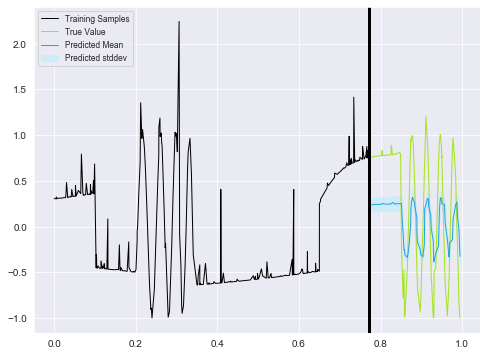

In [58]:
fig = plt.figure(figsize=(8, 6))
l = x_train.shape[0]

x_train_plot, y_train_plot = x_train.flatten()[:int((training + validation) * l)], y_train.flatten()[:int((training + validation) * l)]
x_test_plot = np.concatenate((np.expand_dims(x_train_plot[-1], axis=0), x_train.flatten()[int((training + validation) * l):]))
y_test_plot = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), y_train.flatten()[int((training + validation) * l):]))
y_pred_plot = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), res_mean))
y_pred_upper = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), res_mean + np.sqrt(res_var)))
y_pred_lower = np.concatenate((np.expand_dims(y_train_plot[-1], axis=1), res_mean - np.sqrt(res_var)))

print("MAPE: ", get_mape(y_test_plot, y_pred_plot))
plt.plot(x_train_plot, y_train_plot, color='k', linewidth=1)
plt.plot(x_test_plot, y_test_plot, color='#a5e321', linewidth=1)
plt.plot(x_test_plot, y_pred_plot, color='#21a5e3', linewidth=1)
plt.fill_between(x_test_plot, y1=y_pred_upper, y2=y_pred_lower, color='#cdebf9')
plt.legend(('Training Samples', 'True Value', 'Predicted Mean', 'Predicted stddev'), loc='upper left',
            fontsize='small', fancybox=True)
plt.axvline(x=x_train_plot[-1], color='k', linestyle='-', linewidth=3)
# plt.tick_params(labelsize=6)

## Quantile Loss

In [59]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = torch.squeeze(target) - preds[:, i]
            losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
        loss = torch.sum(torch.cat(losses, dim=1))
        return loss

In [60]:
criterion = QuantileLoss([0.05, 0.5, 0.95])
model = RNNModel(input_dim=1, hidden_dim=5, layer_dim=2, nonlinearity='tanh', quantiles=[0.05, 0.5, 0.95])
optim = torch.optim.Adam(model.parameters(), lr=lr)
best_val = 10000000
print('Begin training for quantile estimator...')
start = time.time()
for epoch in range(1, num_epoch):
    train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, batch_size)
    val_loss = evaluate(Data, Data.valid[0], Data.valid[1], model, criterion, batch_size)
    if epoch % 10 == 0:
        print('Epoch [{:3d}]: training loss {:5.4f} | validation loss {:5.4f}.'.format(epoch, train_loss, val_loss))
    if val_loss < best_val:
        with open('./saved_model/quantile_rnn.pt', 'wb') as f:
            torch.save(model, f)
        best_val = val_loss
print('Training time: ', time.time() - start)

with open('./saved_model/quantile_rnn.pt', 'rb') as f:
    model = torch.load(f)
result = model(Data.test[0]).cpu().detach().numpy()


Begin training for quantile estimator...


/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/hanxing/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__nam

Epoch [ 10]: training loss 0.4455 | validation loss 1.0677.
Epoch [ 20]: training loss 0.3450 | validation loss 0.6903.
Epoch [ 30]: training loss 0.2892 | validation loss 0.5284.
Epoch [ 40]: training loss 0.2688 | validation loss 0.4800.
Epoch [ 50]: training loss 0.2427 | validation loss 0.4121.
Epoch [ 60]: training loss 0.2160 | validation loss 0.3248.
Epoch [ 70]: training loss 0.1959 | validation loss 0.2153.
Epoch [ 80]: training loss 0.1809 | validation loss 0.1284.
Epoch [ 90]: training loss 0.1702 | validation loss 0.1090.
Epoch [100]: training loss 0.1626 | validation loss 0.1107.
Epoch [110]: training loss 0.1573 | validation loss 0.1110.
Epoch [120]: training loss 0.1539 | validation loss 0.1092.
Epoch [130]: training loss 0.1514 | validation loss 0.1072.
Epoch [140]: training loss 0.1484 | validation loss 0.1067.
Epoch [150]: training loss 0.1457 | validation loss 0.1001.
Epoch [160]: training loss 0.1416 | validation loss 0.1017.
Epoch [170]: training loss 0.1386 | vali

/Users/hanxing/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # Remove the CWD from sys.path while we load stuff.


Gaussian MAPE: 73.6975370896044, quantile MAPE: 62.20284916435773
Gaussian LLH: 0.7489846131953241, quantile LLH: 0.5649155102991416


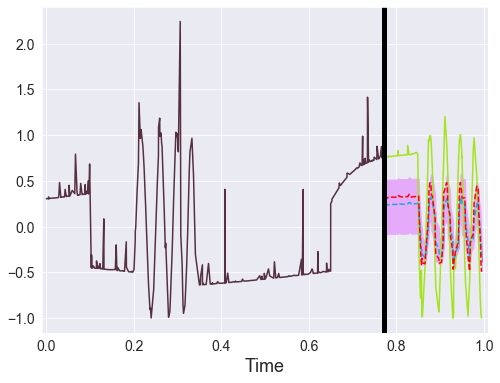

In [61]:
fig = plt.figure(figsize=(8, 6))
l = x_train.shape[0]

x_train_plot, y_train_plot = x_train.flatten()[:int((training + validation) * l)], y_train.flatten()[:int((training + validation) * l)]
x_test_plot = np.concatenate((np.expand_dims(x_train_plot[-1], axis=0), x_train.flatten()[int((training + validation) * l):]))
y_test_plot = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), y_train.flatten()[int((training + validation) * l):]))

y_pred_plot = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), res_mean))
y_pred_upper = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), res_mean + np.sqrt(res_var)))
y_pred_lower = np.concatenate((np.expand_dims(y_train_plot[-1], axis=1), res_mean - np.sqrt(res_var)))

y_pred_plot_quantile = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), result[:, 1]))
y_pred_upper_quantile = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), result[:, 2]))
y_pred_lower_quantile = np.concatenate((np.expand_dims(y_train_plot[-1], axis=0), result[:, 0]))

upper_loss, lower_loss, median_loss = QuantileLoss([0.95]), QuantileLoss([0.05]), QuantileLoss([0.5])
print("Gaussian MAPE: {}, quantile MAPE: {}".format(get_mape(y_test_plot, y_pred_plot), 
                                                    get_mape(y_test_plot, y_pred_plot_quantile)))
print("Gaussian LLH: {}, quantile LLH: {}".format(
    get_llh(y_test_plot, y_pred_upper, y_pred_plot, y_pred_lower, np.percentile(Data.test[0], 95, axis=1),
                       np.percentile(Data.test[0], 50, axis=1), np.percentile(Data.test[0], 5, axis=1), upper_loss,
                       median_loss, lower_loss), 
    get_llh(y_test_plot, y_pred_upper_quantile, y_pred_plot_quantile, y_pred_lower_quantile, np.percentile(Data.test[0], 95, axis=1),
                       np.percentile(Data.test[0], 50, axis=1), np.percentile(Data.test[0], 5, axis=1), upper_loss,
                       median_loss, lower_loss)))

sns.set_style("darkgrid")
plt.plot(x_train_plot, y_train_plot, color='#543041', linewidth=1.5)
plt.plot(x_test_plot, y_test_plot, color='#a5e321', linewidth=1.5)
plt.plot(x_test_plot, y_pred_plot, color='#21a5e3', linewidth=1.5, ls='--')
plt.fill_between(x_test_plot, y1=y_pred_upper, y2=y_pred_lower, color='#582863')
# ---------------------
plt.plot(x_test_plot, y_pred_plot_quantile, color='#fc0303', linewidth=1.5, ls='--')
plt.fill_between(x_test_plot, y1=y_pred_upper_quantile, y2=y_pred_lower_quantile, color='#e6aafa')
# ---------------------
# plt.legend(('Training Samples', 'True Value', 'Gaussian Predicted Mean', 'Quantile Predicted Mean', 
#             'Gaussian Predicted stddev', 'Quantile Predicted stddev'), loc='lower left',
#             fontsize='x-large', fancybox=True)
plt.axvline(x=x_train_plot[-1], color='k', linestyle='-', linewidth=5)
plt.tick_params(labelsize=14)
plt.xlabel('Time', fontsize=18)
plt.xlim([-0.01, 1.01])
plt.xticks(np.arange(0., 1.01, .2), fontsize=14)
plt.savefig('./Gaussian_piecewise.pdf')